In [12]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.metrics import Mean
from keras.losses import binary_crossentropy
from tensorflow.keras import layers, Model
from keras.saving import register_keras_serializable

In [14]:
import zipfile
ZIP_PATH    = '/content/drive/MyDrive/celeba.zip'
EXTRACT_DIR = '/content/celeba'

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_DIR)
print(EXTRACT_DIR)

DATA_DIR = os.path.join(EXTRACT_DIR, "celeba")
print("DATA_DIR =", DATA_DIR)

/content/celeba
DATA_DIR = /content/celeba/celeba


In [15]:
# hyperameters

IMG_H, IMG_W, IMG_C = 128, 128, 3
LATENT_DIM         = 64
BATCH_SIZE         = 64
EPOCHS             = 150
SMILE_ATTR_FILE    = "list_attr_celeba.csv"

In [16]:
attr_path = os.path.join(DATA_DIR, SMILE_ATTR_FILE)

df = pd.read_csv(attr_path)
# Keep only the filename and the Smiling column, then remap +1→1, -1→0
df = df[["image_id","Smiling"]].rename(columns={"image_id":"filename"})
df["label"] = df["Smiling"].map({1:1, -1:0})
smile_map = dict(zip(df["filename"], df["label"]))

# Locate the nested image folder
outer = os.path.join(DATA_DIR, "img_align_celeba")
print("Outer contents:", os.listdir(outer)[:5])
# Expect a single sub‑directory named "img_align_celeba"
inner = os.path.join(outer, os.listdir(outer)[0])
print("Using image folder:", inner)

# Gather all .jpg files and corresponding labels
all_files = sorted(f for f in os.listdir(inner) if f.lower().endswith(".jpg"))
print(f"Found {len(all_files)} images; sample:", all_files[:5])
file_paths = [os.path.join(inner, fn) for fn in all_files]
labels     = [smile_map[fn]               for fn in all_files]

Outer contents: ['img_align_celeba']
Using image folder: /content/celeba/celeba/img_align_celeba/img_align_celeba
Found 202599 images; sample: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']


In [17]:
# split train/test
split = int(0.8 * len(file_paths))
train_paths, train_labels = file_paths[:split], labels[:split]
test_paths,  test_labels  = file_paths[split:], labels[split:]

In [18]:
# Preprocessing function
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.central_crop(img, 0.8)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = img / 255.0
    return img, label

# Build tf.data.Dataset pipelines
def make_ds(paths, labs):
    ds = tf.data.Dataset.from_tensor_slices((paths, labs))
    ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_labels)
test_ds  = make_ds(test_paths,  test_labels)

for imgs, labs in train_ds.take(1):
    print("Batch shape:", imgs.shape, "Labels present:", tf.unique(labs).y.numpy())

Batch shape: (64, 128, 128, 3) Labels present: [1 0]


In [19]:
# Encoder
enc_input = layers.Input(shape=(IMG_H, IMG_W, IMG_C))

x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(enc_input)
x = layers.Conv2D(128,4, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(256,4, strides=2, padding="same", activation="relu")(x)
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]  # (H,W,C)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)

z_mean   = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_logvar = layers.Dense(LATENT_DIM, name="z_logvar")(x)

# Sampling layer
class Sampler(layers.Layer):
    def call(self, z_mean, z_logvar):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps

z = Sampler()(z_mean, z_logvar)
encoder = Model(enc_input, [z_mean, z_logvar, z], name="encoder")


In [20]:
# Decoder
dec_input = layers.Input(shape=(LATENT_DIM,))
x = layers.Dense(np.prod(shape_before_flatten), activation="relu")(dec_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64,  4, strides=2, padding="same", activation="relu")(x)
dec_output = layers.Conv2D(IMG_C, 3, activation="sigmoid", padding="same")(x)

decoder = Model(dec_input, dec_output, name="decoder")

In [21]:
@register_keras_serializable()
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker    = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
      z_mean, z_logvar, z = self.encoder(inputs)
      return self.decoder(z)

    def train_step(self, data):
        imgs, _ = data
        with tf.GradientTape() as tape:
            z_mean, z_logvar, z = self.encoder(imgs)
            recon = self.decoder(z)
            bce = tf.keras.losses.binary_crossentropy(imgs, recon)  # (B,H,W)
            recon_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=(1,2)))

            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1))

            total_loss = recon_loss + kl_loss


        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon": self.recon_loss_tracker.result(),
            "kl": self.kl_loss_tracker.result()
        }

In [22]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.MeanSquaredError())

# Train on 80% data, validate on 20%
vae.fit(train_ds, epochs=EPOCHS)

vae.save("/content/drive/MyDrive/vae_smile_model.keras")

Epoch 1/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 78s 25ms/step - kl: 72.5299 - loss: 9476.5869 - recon: 9404.0586
Epoch 2/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 102.2168 - loss: 8720.2100 - recon: 8617.9893
Epoch 3/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 99.4972 - loss: 8659.2109 - recon: 8559.7197
Epoch 4/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 96.6464 - loss: 8631.6416 - recon: 8534.9990
Epoch 5/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 93.5383 - loss: 8616.4824 - recon: 8522.9385
Epoch 6/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 91.3015 - loss: 8602.0645 - recon: 8510.7656
Epoch 7/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 89.7572 - loss: 8592.2285 - recon: 8502.4756
Epoch 8/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 88.6699 - loss: 8585.9912 - recon: 8497.3242
Epoch 9/150
2533/2533 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - kl: 87.9315 - loss: 8580.1348 - recon: 8492.2070
Epoch 10/150
2533/2533 ━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [23]:
vae(tf.zeros((1, 128, 128, 3)))

vae.save("/content/drive/MyDrive/vae_smile_model_1.keras")

In [61]:
# compute the smile attributer
# Encode test images by label (smiling vs. not smiling):

z_means = []
z_labels = []

for imgs, labels in test_ds:
    z_mean, _, _ = vae.encoder(imgs)
    z_means.append(z_mean)
    z_labels.append(labels)

z_means = tf.concat(z_means, axis=0)
z_labels = tf.concat(z_labels, axis=0)


In [62]:
# seperate smile vs no-smile

smile_z = z_means[z_labels == 1]
no_smile_z = z_means[z_labels == 0]

# Compute smile vector (direction in latent space):
smile_vector = tf.reduce_mean(smile_z, axis=0) - tf.reduce_mean(no_smile_z, axis=0)


In [96]:
for imgs, labels in test_ds.take(1):
    test_imgs = imgs[:2]
    z_mean, _, _ = vae.encoder(test_imgs)

# Create modified versions
z_more_smile = z_mean + 1.0 * smile_vector
z_less_smile = z_mean - 1.0 * smile_vector

recon_more_smile = vae.decoder(z_more_smile)
recon_less_smile = vae.decoder(z_less_smile)

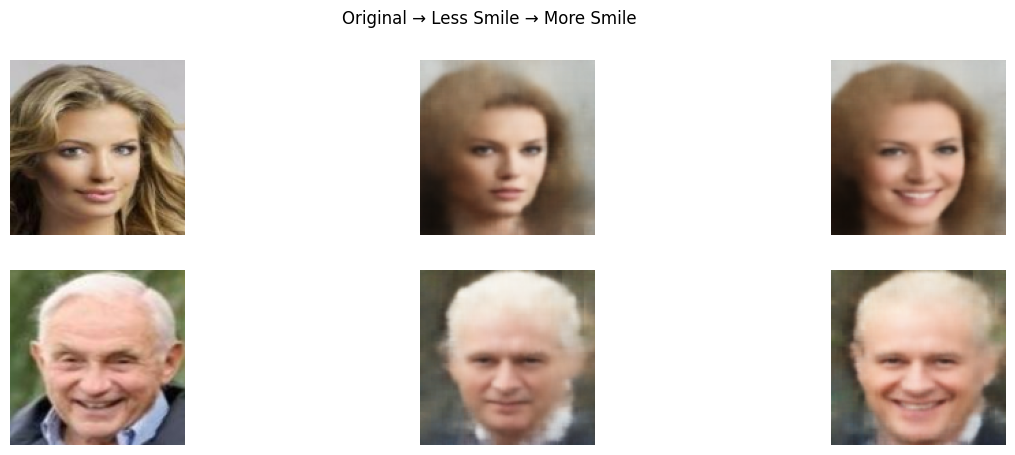

In [97]:
# visualization

import matplotlib.pyplot as plt

def show_images(original, less_smile, more_smile):
    n = original.shape[0]
    plt.figure(figsize=(15, 5))
    for i in range(n):
        for j, img in enumerate([original[i], less_smile[i], more_smile[i]]):
            plt.subplot(n, 3, i * 3 + j + 1)
            plt.imshow(img.numpy())
            plt.axis('off')
    plt.suptitle("Original → Less Smile → More Smile")
    plt.show()

show_images(test_imgs, recon_less_smile, recon_more_smile)


In [98]:
# smile_vector = smile_mean - neutral_mean  # (or similar logic)

np.save("/content/drive/MyDrive/smile_vector.npy", smile_vector)